# July 16th, 2018
## Benjamin Adam Catching
## Andino Lab Rotation
## Polio DIPs Project

In [442]:
# For data display
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pprint

# Necessary for analysis
import numpy as np
import skimage.filters
import skimage.morphology
import skimage.io
import skimage.segmentation
import skimage.exposure
import skimage.feature
import scipy.ndimage

In [470]:
class Bulk_droplet:
    """Create an image object from the read in file"""
    
    def __init__(self, filename, micron_per_pixel=1, gfp_thresh=0, multi_channel=False,
                testing=False):
        """Initialize the image data"""
        
        # Define input image attributes
        self.filename = filename
        self.image = skimage.io.imread(filename)
        self.micron_per_pixel = micron_per_pixel
        self.gfp_thresh = gfp_thresh
        self.shape = self.image.shape
        self.multi_channel = multi_channel
        
    def droplet_segment(self, testing=False):
        """Return droplets and their properties"""
        
        # If the image has multiple channels, choose the channel to determine droplets from
        if self.multi_channel:
            bright_channel = int(input('Input brightfield channel: '))
            image_bright = (self.image)[:, :, bright_channel]
        else:
            image_bright = self.image

        # Find the Otsu threshold
        bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)
        
        # Label thesholded images
        bright_threshold = image_bright > bright_thresh_otsu
        image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)
        
        # Get the properties of the labeled regions
        image_props = skimage.measure.regionprops(image_labeled)

        # Create a blank region of the original image
        blank_background= np.zeros(image_bright.shape)
        
        for index, prop in enumerate(image_props):
            #print(prop.area)
            # If the region properties are within the threshold
            if prop.area >= 10000 and prop.eccentricity <= 0.4:
                # Select the region
                #print(index)
                """temp_seg = image_labeled==index+1
                filled_seg = temp_seg"""
                # Set the center of the circle
                (center_x, center_y) = prop.centroid
                radius = prop.major_axis_length / 2
                for (x,y), value in np.ndenumerate(blank_background):
                    dist_x = center_x - x
                    dist_y = center_y - y
                    dist = np.sqrt(dist_x**2 + dist_y**2)
                    if dist < radius:
                        blank_background[x, y] = 1
                # Add the temp region
                #blank_background = blank_background + filled_seg
                                
        # Fill the holes of the image
        image_droplets = scipy.ndimage.binary_fill_holes(blank_background)
        image_droplets = skimage.morphology.closing(image_droplets, selem=skimage.morphology.disk(2))
        image_droplets = skimage.morphology.erosion(image_droplets, selem=skimage.morphology.disk(2))
        
        
        
        # If testing is True, show the image
        if testing:
            with sns.axes_style("dark"):
                # Define the number of pixels in a millimeter
                mm = (1 / self.micron_per_pixel) * 500

                # Define the number of ticks
                num_x_ticks = (image_bright.shape)[1] // mm + 1
                num_y_ticks = (image_bright.shape)[0] // mm + 1
                plt.imshow(image_droplets)
                plt.xticks(np.arange(0, (image_bright.shape)[1], mm), np.arange(0, num_x_ticks))
                plt.yticks(np.arange(0, (image_bright.shape)[0], mm), np.arange(0, num_y_ticks))
                plt.xlabel("x-axis (mm)")
                plt.ylabel("y-axis (mm)")
                plt.title("Segmented Droplets")
                plt.show()
            
        image_labeled, number_labels = skimage.measure.label(image_droplets, background=0, return_num=True)
        
        # Get the properties of the labeled regions
        image_props = skimage.measure.regionprops(image_labeled, image_bright)
        
        # Display the number of complete droplets
        print()
            
        return image_labeled, image_props
    
    def find_brightfield_cells(self):
        """Return the brightfield cells"""
        
        # Call the labeled black-white droplet image and the associated properties
        image_labeled, image_props = self.droplet_segment()
        
        # Define the droplet images
        labeled_droplets, number_droplets = skimage.measure.label(image_labeled, background=0, return_num=True)
        bright_droplet_props = skimage.measure.regionprops(labeled_droplets, image_bright)
        
        return labeled_droplets, bright_droplet_props

In [50]:
# Define the test series of images
HeLa_Fast_filenames = glob.glob("../../data/20180710_Microfludic_picture/HeLa_Fast/*.tif")
HeLa_Fast_filenames = sorted(HeLa_Fast_filenames)
HeLa_Fast_filenames

['../../data/20180710_Microfludic_picture/HeLa_Fast/10_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/10_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_20X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_20X_stox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/2_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/2_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/3_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/3_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/4_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/4_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/5_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/5_40X_sytox.tif',
 '../../data/20180710_Microfludic

In [485]:
# Test the current function on the first set of images
test_image = Bulk_droplet(HeLa_Fast_filenames[6], gfp_thresh=50, multi_channel=True)

Input brightfield channel: 0


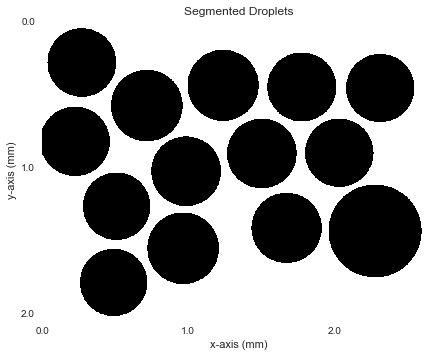

In [486]:
test_image_labeled, test_image_props = test_image.droplet_segment(testing=True)

In [487]:
# Create list of segmented brightfield and GFP droplets
num=6
test_raw_image = skimage.io.imread(HeLa_Fast_filenames[num])
test_gfp_image = skimage.io.imread(HeLa_Fast_filenames[num+1])

In [488]:
bright_droplet_props = skimage.measure.regionprops(test_image_labeled, test_raw_image[:, :, 0])
gfp_droplet_props = skimage.measure.regionprops(test_image_labeled, test_gfp_image[:, :, 1])

In [489]:
# List of segmented droplets 
bright_droplets = []
gfp_droplets = []
droplet_masks = []
for index, prop in enumerate(bright_droplet_props):
    bright_droplets.append(prop.intensity_image)
    gfp_droplets.append(gfp_droplet_props[index].intensity_image)
    droplet_masks.append(prop.image)
    print(prop.eccentricity)

0.018621732141450655
0.006453733184522102
0.03645042461358315
0.026242475881463806
0.013148681805413174
0.1492940728818761
0.020977097561519557
0.029441797556080406
0.02451141764303523
0.03390763684529672
0.015419187173068784
0.015352730584091472
0.02099773463487532
0.02461972962354504


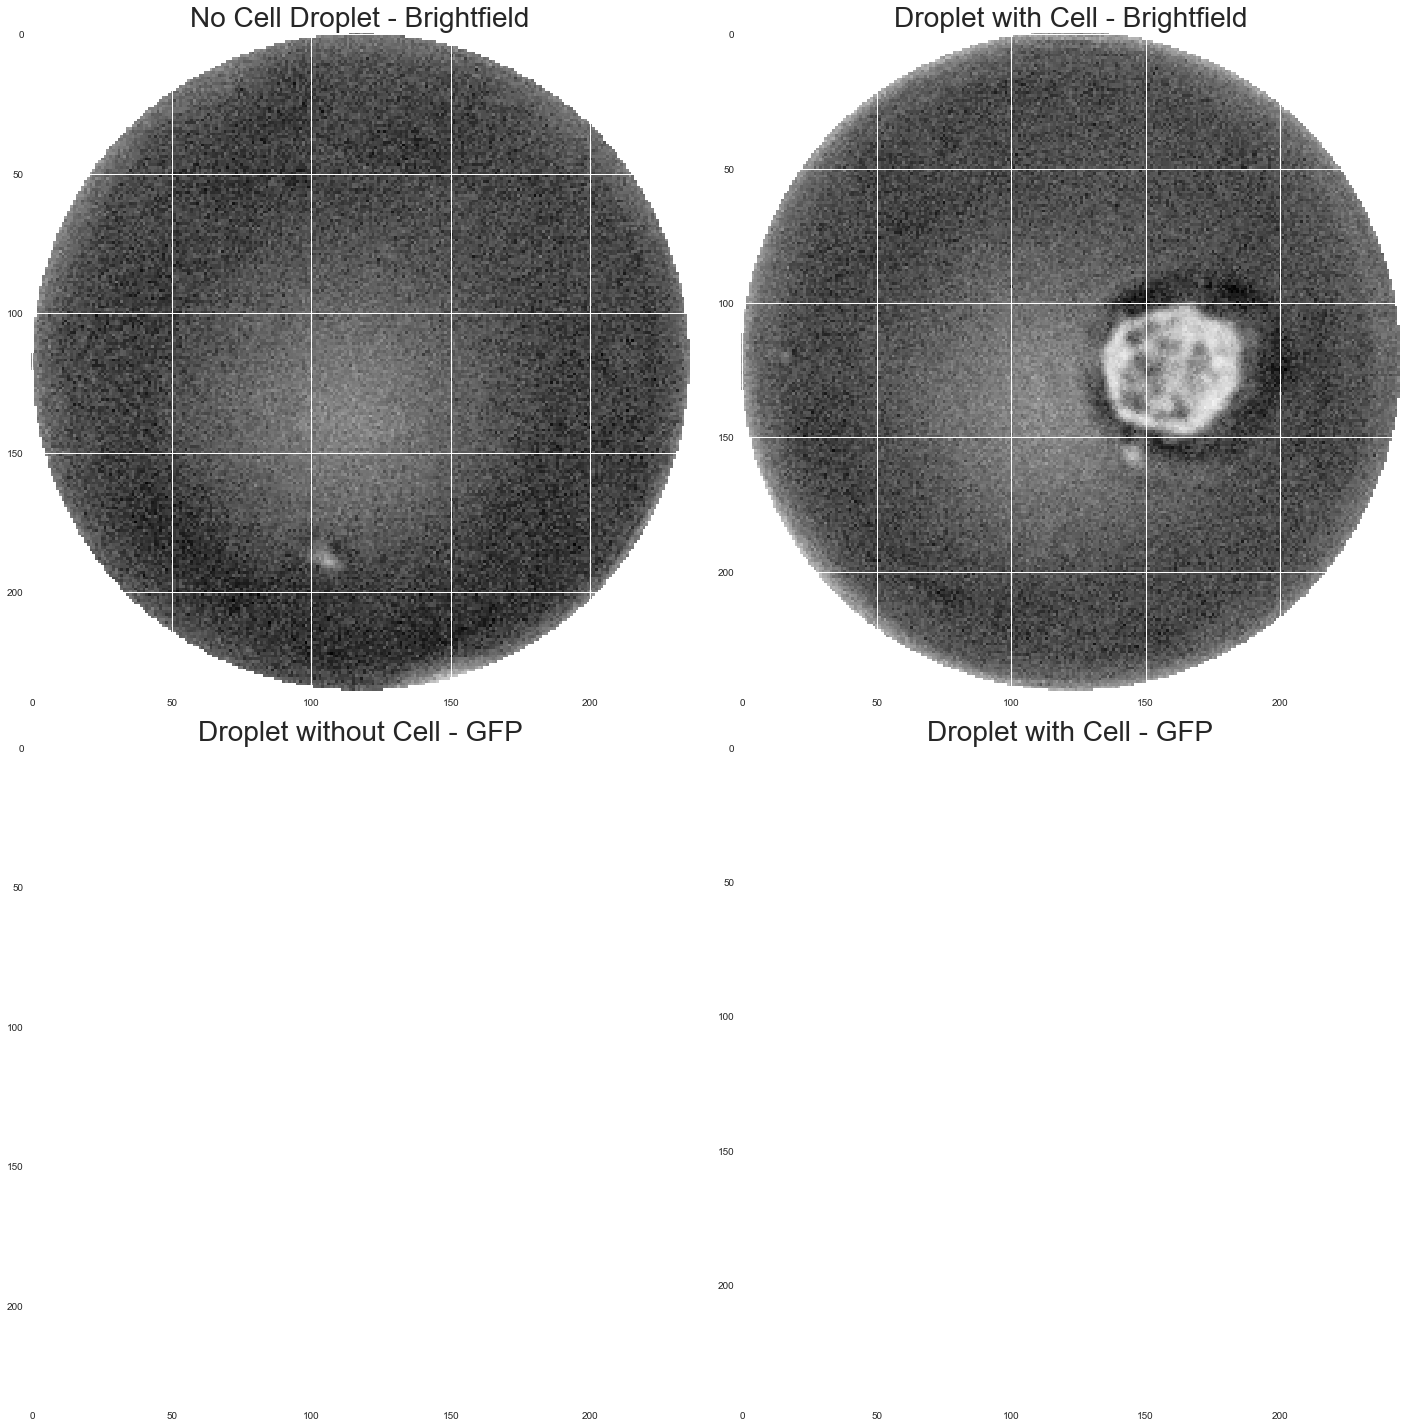

In [510]:
# Define the two segmented images to process; one that contains cells and one that does not
no_cell_num = 0
cell_num = 12


no_cell_droplet = bright_droplets[no_cell_num]
cell_droplet = bright_droplets[cell_num]
no_cell_gfp = gfp_droplets[no_cell_num]
cell_gfp = gfp_droplets[cell_num]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(no_cell_droplet)
ax[0, 0].set_title("No Cell Droplet - Brightfield", size=28)
ax[0, 1].imshow(cell_droplet)
ax[0, 1].set_title("Droplet with Cell - Brightfield", size=28)
ax[1, 0].imshow(no_cell_gfp > 50)
ax[1, 0].set_title("Droplet without Cell - GFP", size=28)
ax[1, 1].imshow(cell_gfp > 50)
ax[1, 1].set_title("Droplet with Cell - GFP", size=28)
plt.tight_layout()
plt.show()

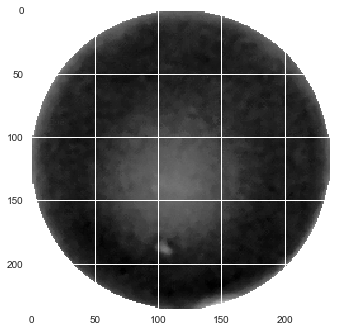

In [511]:
# Threshold based on a medium gaussian blur subtraction then thresholding

# Remove any hot pixels
selem = skimage.morphology.disk(3)
no_cell_median = skimage.filters.median(no_cell_droplet, selem)
cell_median = skimage.filters.median(cell_droplet, selem)

no_cell_gaussian_blur = skimage.filters.gaussian(no_cell_median, sigma=15)
cell_gaussian_blur = skimage.filters.gaussian(cell_median, sigma=15)

no_cell_sub_gaussian = no_cell_median - no_cell_gaussian_blur
cell_sub_gaussian = cell_median - cell_gaussian_blur

plt.imshow(no_cell_sub_gaussian)
plt.show()

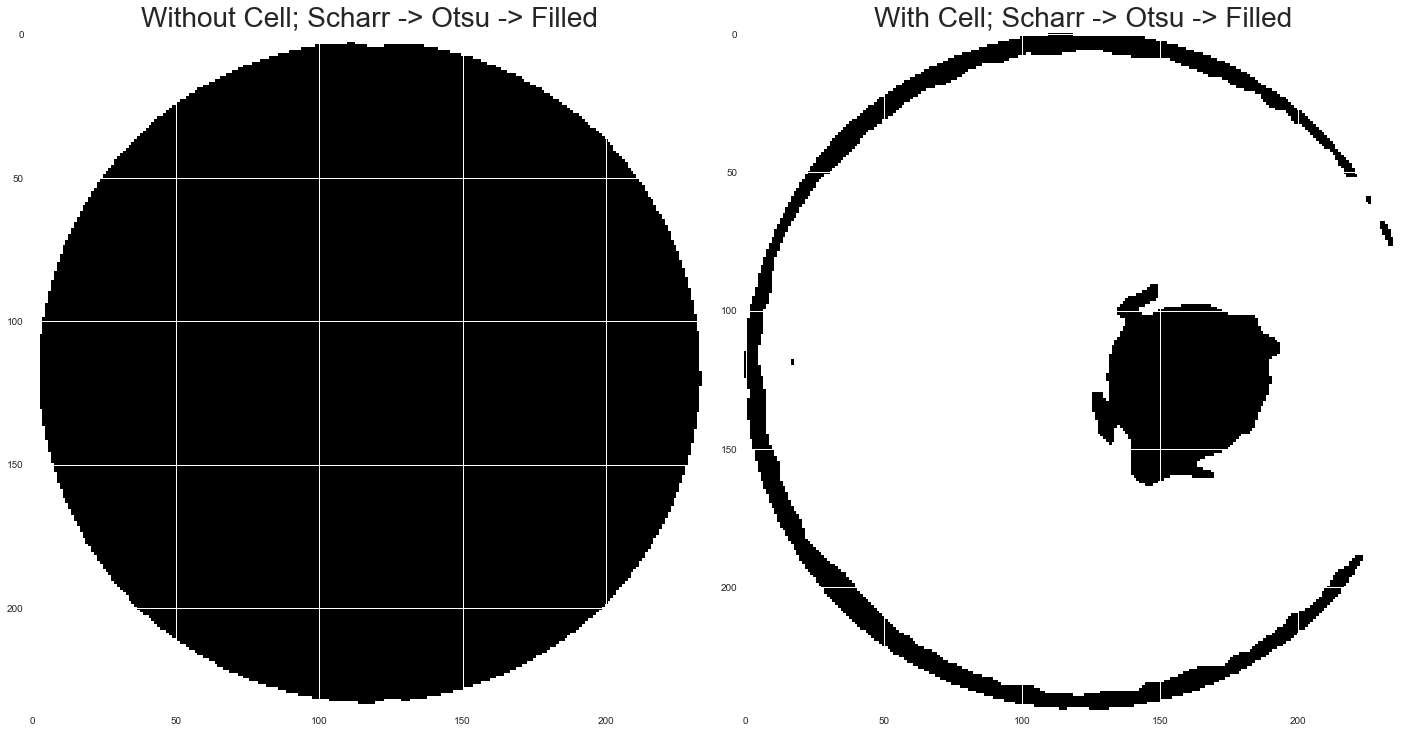

In [512]:
# Perform a Scharr operation on the no cell droplet
no_cell_temp_scharr = skimage.filters.scharr(no_cell_sub_gaussian, droplet_masks[no_cell_num])
# Otsu threshold the scharr image
no_cell_thresh = skimage.filters.threshold_otsu(no_cell_temp_scharr)
# Fill holes created from the otsu threshold
no_cell_filled = scipy.ndimage.binary_fill_holes(no_cell_temp_scharr > no_cell_thresh)
# Try to fill any partial no_cell_filled
"""no_cell = skimage.morphology.binary_closing(no_cell_filled)
no_cell = scipy.ndimage.binary_fill_holes(no_cell)
no_cell = skimage.morphology.erosion(no_cell)"""
no_cell = skimage.filters.gaussian(no_cell_filled, 2)
no_cell = no_cell > .75

# Perform a Scharr operation on the no cell droplet
cell_temp_scharr = skimage.filters.scharr(cell_sub_gaussian, droplet_masks[cell_num])
# Otsu threshold the scharr image
cell_thresh = skimage.filters.threshold_otsu(cell_temp_scharr)
# Fill holes created from the otsu threshold
cell_filled = scipy.ndimage.binary_fill_holes(cell_temp_scharr > cell_thresh)
# Try to fill any partial cells
"""cell = skimage.morphology.binary_closing(cell_filled, skimage.morphology.disk(3))
cell = scipy.ndimage.binary_fill_holes(cell)
cell = skimage.morphology.erosion(cell)"""
cell = skimage.filters.gaussian(cell_filled, 2)
cell = cell > .25
#cell = skimage.morphology.erosion(cell)


# Plot the two images
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(no_cell)
ax[0].set_title("Without Cell; Scharr -> Otsu -> Filled", size=28)
ax[1].imshow(cell)
ax[1].set_title("With Cell; Scharr -> Otsu -> Filled", size=28)
plt.tight_layout()
plt.show()

In [513]:
# Now that objects have been thresholded in the droplets, label and get props
no_cell_labels = skimage.measure.label(no_cell, background=0, return_num=False)
cell_labels = skimage.measure.label(cell, background=0, return_num=False)

In [514]:
# Get regionprops and filter based on them
no_cell_props = skimage.measure.regionprops(no_cell_labels)
cell_props = skimage.measure.regionprops(cell_labels)

# Create a blank region of the original image
no_cell_droplet_cells = np.zeros(no_cell_droplet.shape)
cell_droplet_cells = np.zeros(cell_droplet.shape)

# First with no cells
for index, prop in enumerate(no_cell_props):
    #print(prop.area)
    # If the region properties are within the threshold
    if prop.area <= 10000 and prop.area >= 1500:
        # Select the region
        #print(index)
        temp_seg = no_cell_labels==index+1
        filled_seg = temp_seg
        # Add to the blank image
        no_cell_droplet_cells = no_cell_droplet_cells + filled_seg
        
# Now with cells
for index, prop in enumerate(cell_props):
    #print(prop.area)
    # If the region properties are within the threshold
    if prop.area <= 10000 and prop.area >= 1500  and prop.extent > .2:
        # Select the region
        temp_seg = cell_labels==index+1
        filled_seg = temp_seg
        # Add to the blank image
        cell_droplet_cells = cell_droplet_cells + filled_seg
        # Show the 'density' of pixels
        print(prop.extent)
                

0.636180499597


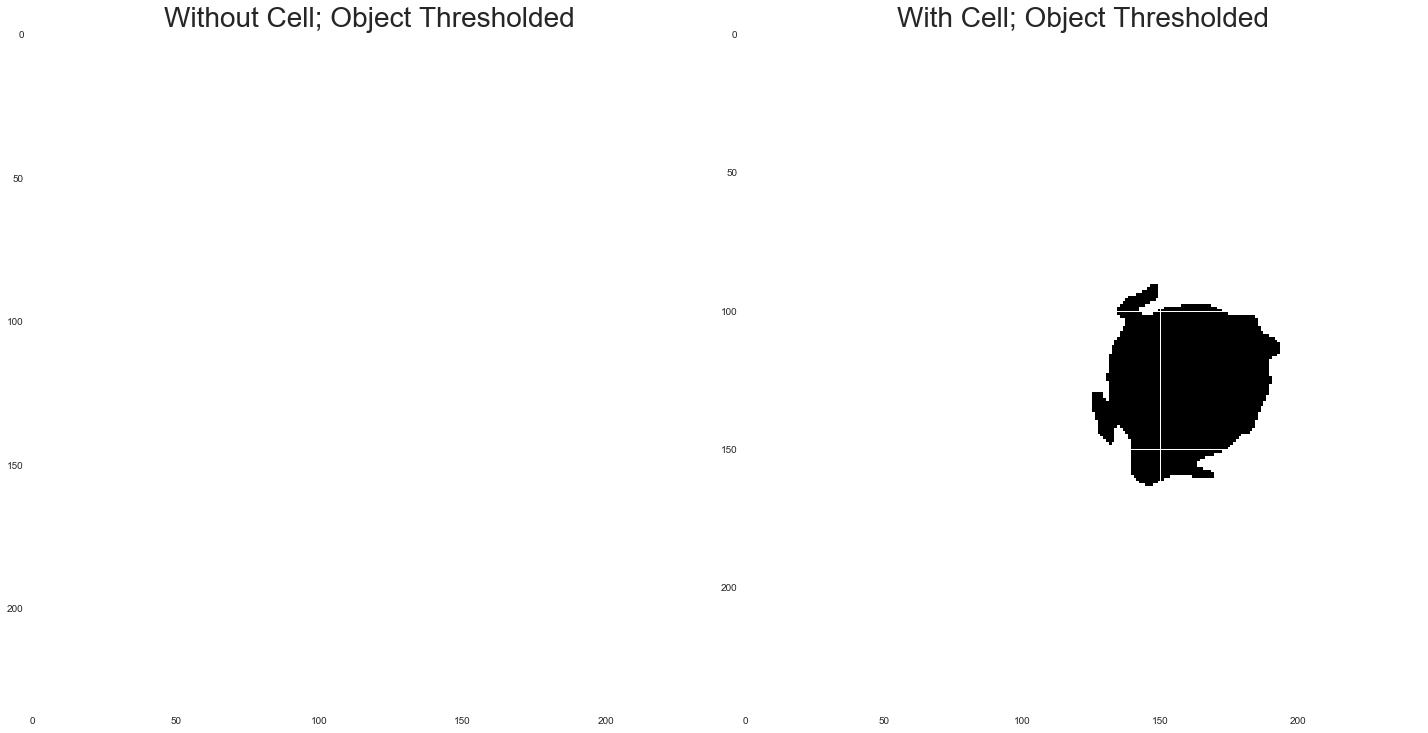

In [515]:
# Plot the two thresholded droplets


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(no_cell_droplet_cells)
ax[0].set_title("Without Cell; Object Thresholded", size=28)
ax[1].imshow(cell_droplet_cells)
ax[1].set_title("With Cell; Object Thresholded", size=28)
plt.tight_layout()
plt.show()

Condense the workflow above into a function that takes the labeled image, image props, and brightfield image to produce a mask image of cells.

In [526]:
def cells_from_droplet(labeled_image, raw_bright, droplet_num, testing=False):
    """
    From segmented black-white droplets, the brightfield image; single channel, and the
    selection of which droplet, return a black-white mask of the cells in the droplet
    """
    
    bright_droplet_props = skimage.measure.regionprops(labeled_image, raw_bright)
    
    # List of segmented droplets 
    bright_droplets = []
    droplet_masks = []

    for index, prop in enumerate(bright_droplet_props):
        bright_droplets.append(prop.intensity_image)
        droplet_masks.append(prop.image)
        
    # Assign images
    cell_droplet = bright_droplets[droplet_num]
    cell_droplet_gfp = gfp_droplets[droplet_num]
    
    # Remove any hot pixels
    selem = skimage.morphology.disk(3)
    cell_droplet_median = skimage.filters.median(cell_droplet, selem)
    
    # Create a gaussian blur of the image and subtract from median image
    cell_droplet_gaussian_blur = skimage.filters.gaussian(cell_droplet_median, sigma=15)
    cell_droplet_sub_gaussian = cell_droplet_median - cell_droplet_gaussian_blur
    
    # Perform a Scharr operation on the no cell droplet
    cell_droplet_temp_scharr = skimage.filters.scharr(cell_droplet_sub_gaussian, droplet_masks[droplet_num])
    # Otsu threshold the scharr image
    cell_droplet_thresh = skimage.filters.threshold_otsu(cell_droplet_temp_scharr)
    # Fill holes created from the otsu threshold
    cell_droplet_filled = scipy.ndimage.binary_fill_holes(cell_droplet_temp_scharr > cell_droplet_thresh)
    # Try to fill any partial no_cell_filled
    """no_cell = skimage.morphology.binary_closing(no_cell_filled)
    no_cell = scipy.ndimage.binary_fill_holes(no_cell)
    no_cell = skimage.morphology.erosion(no_cell)"""
    blur_droplet_cells = skimage.filters.gaussian(cell_droplet_filled, 2)
    smooth_droplet_cells = blur_droplet_cells > .25
    
    # Now that objects have been thresholded in the droplets, label and get props
    cell_droplet_labels = skimage.measure.label(smooth_droplet_cells, background=0, return_num=False)
    
    # Get regionprops and filter based on them
    cell_droplet_props = skimage.measure.regionprops(cell_droplet_labels)
    
    # Create a blank region of the original image
    all_cells = np.zeros(cell_droplet.shape)
    
    """if testing:
        # Plot the two images
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(no_cell)
        ax[0].set_title("Original Image", size=28)
        ax[1].imshow(cell)
        ax[1].set_title("With Cell; Scharr -> Otsu -> Filled", size=28)
        plt.tight_layout()
        plt.show()"""

    # First with no cells
    for index, prop in enumerate(cell_droplet_props):
        #print(prop.area)
        # If the region properties are within the threshold
        if prop.area <= 10000 and prop.area >= 1500 and prop.extent > .2 :
            # Select the region
            #print(index)
            temp_seg = cell_droplet_labels==index+1
            filled_seg = temp_seg
            # Add to the blank image
            all_cells = all_cells + filled_seg

    return all_cells

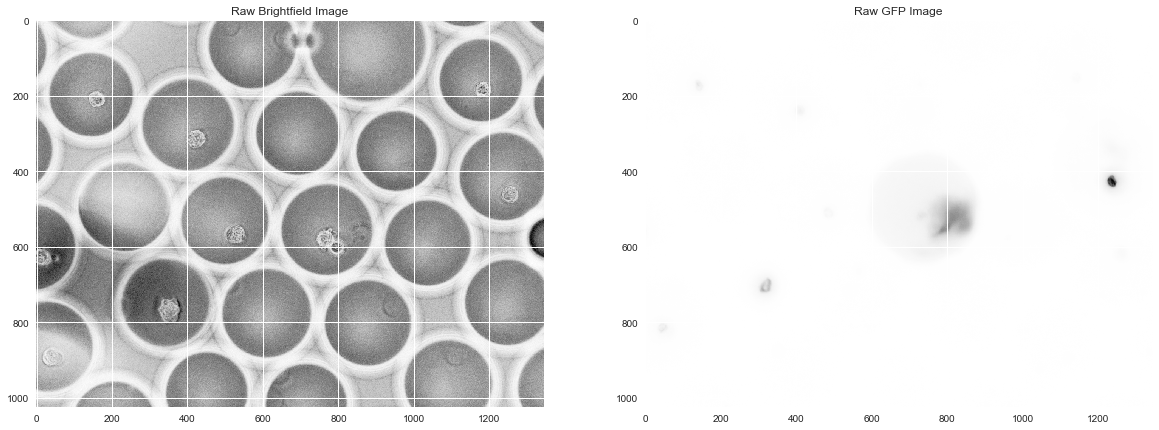

In [621]:
# New images to be read in
num=14
test_raw_image = skimage.io.imread(HeLa_Fast_filenames[num])[:, :, 0]
test_gfp_image = skimage.io.imread(HeLa_Fast_filenames[num+1])[:, :, 1]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(test_raw_image)
ax[1].imshow(test_gfp_image)
ax[0].set_title("Raw Brightfield Image")
ax[1].set_title("Raw GFP Image")
plt.show()

Input brightfield channel: 0


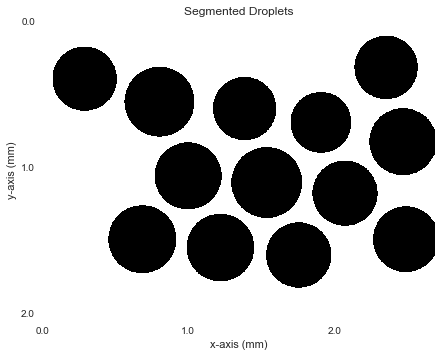

In [622]:
# Test the current function on the first set of images
test_image = Bulk_droplet(HeLa_Fast_filenames[num], gfp_thresh=50, multi_channel=True)
test_droplet = test_image.droplet_segment(testing=True)

In [623]:
test_image_labeled, test_image_props = test_droplet
gfp_droplet_props = skimage.measure.regionprops(test_image_labeled, test_gfp_image)
gfp_droplets = []
for index, prop in enumerate(gfp_droplet_props):
    gfp_droplets.append(prop.intensity_image)
len(gfp_droplets)

13

In [624]:
# All droplet_cells
droplet_cells_list = []
for i in range(len(test_image_props)):
    droplet_cells_list.append(cells_from_droplet(test_image_labeled, test_raw_image, i))

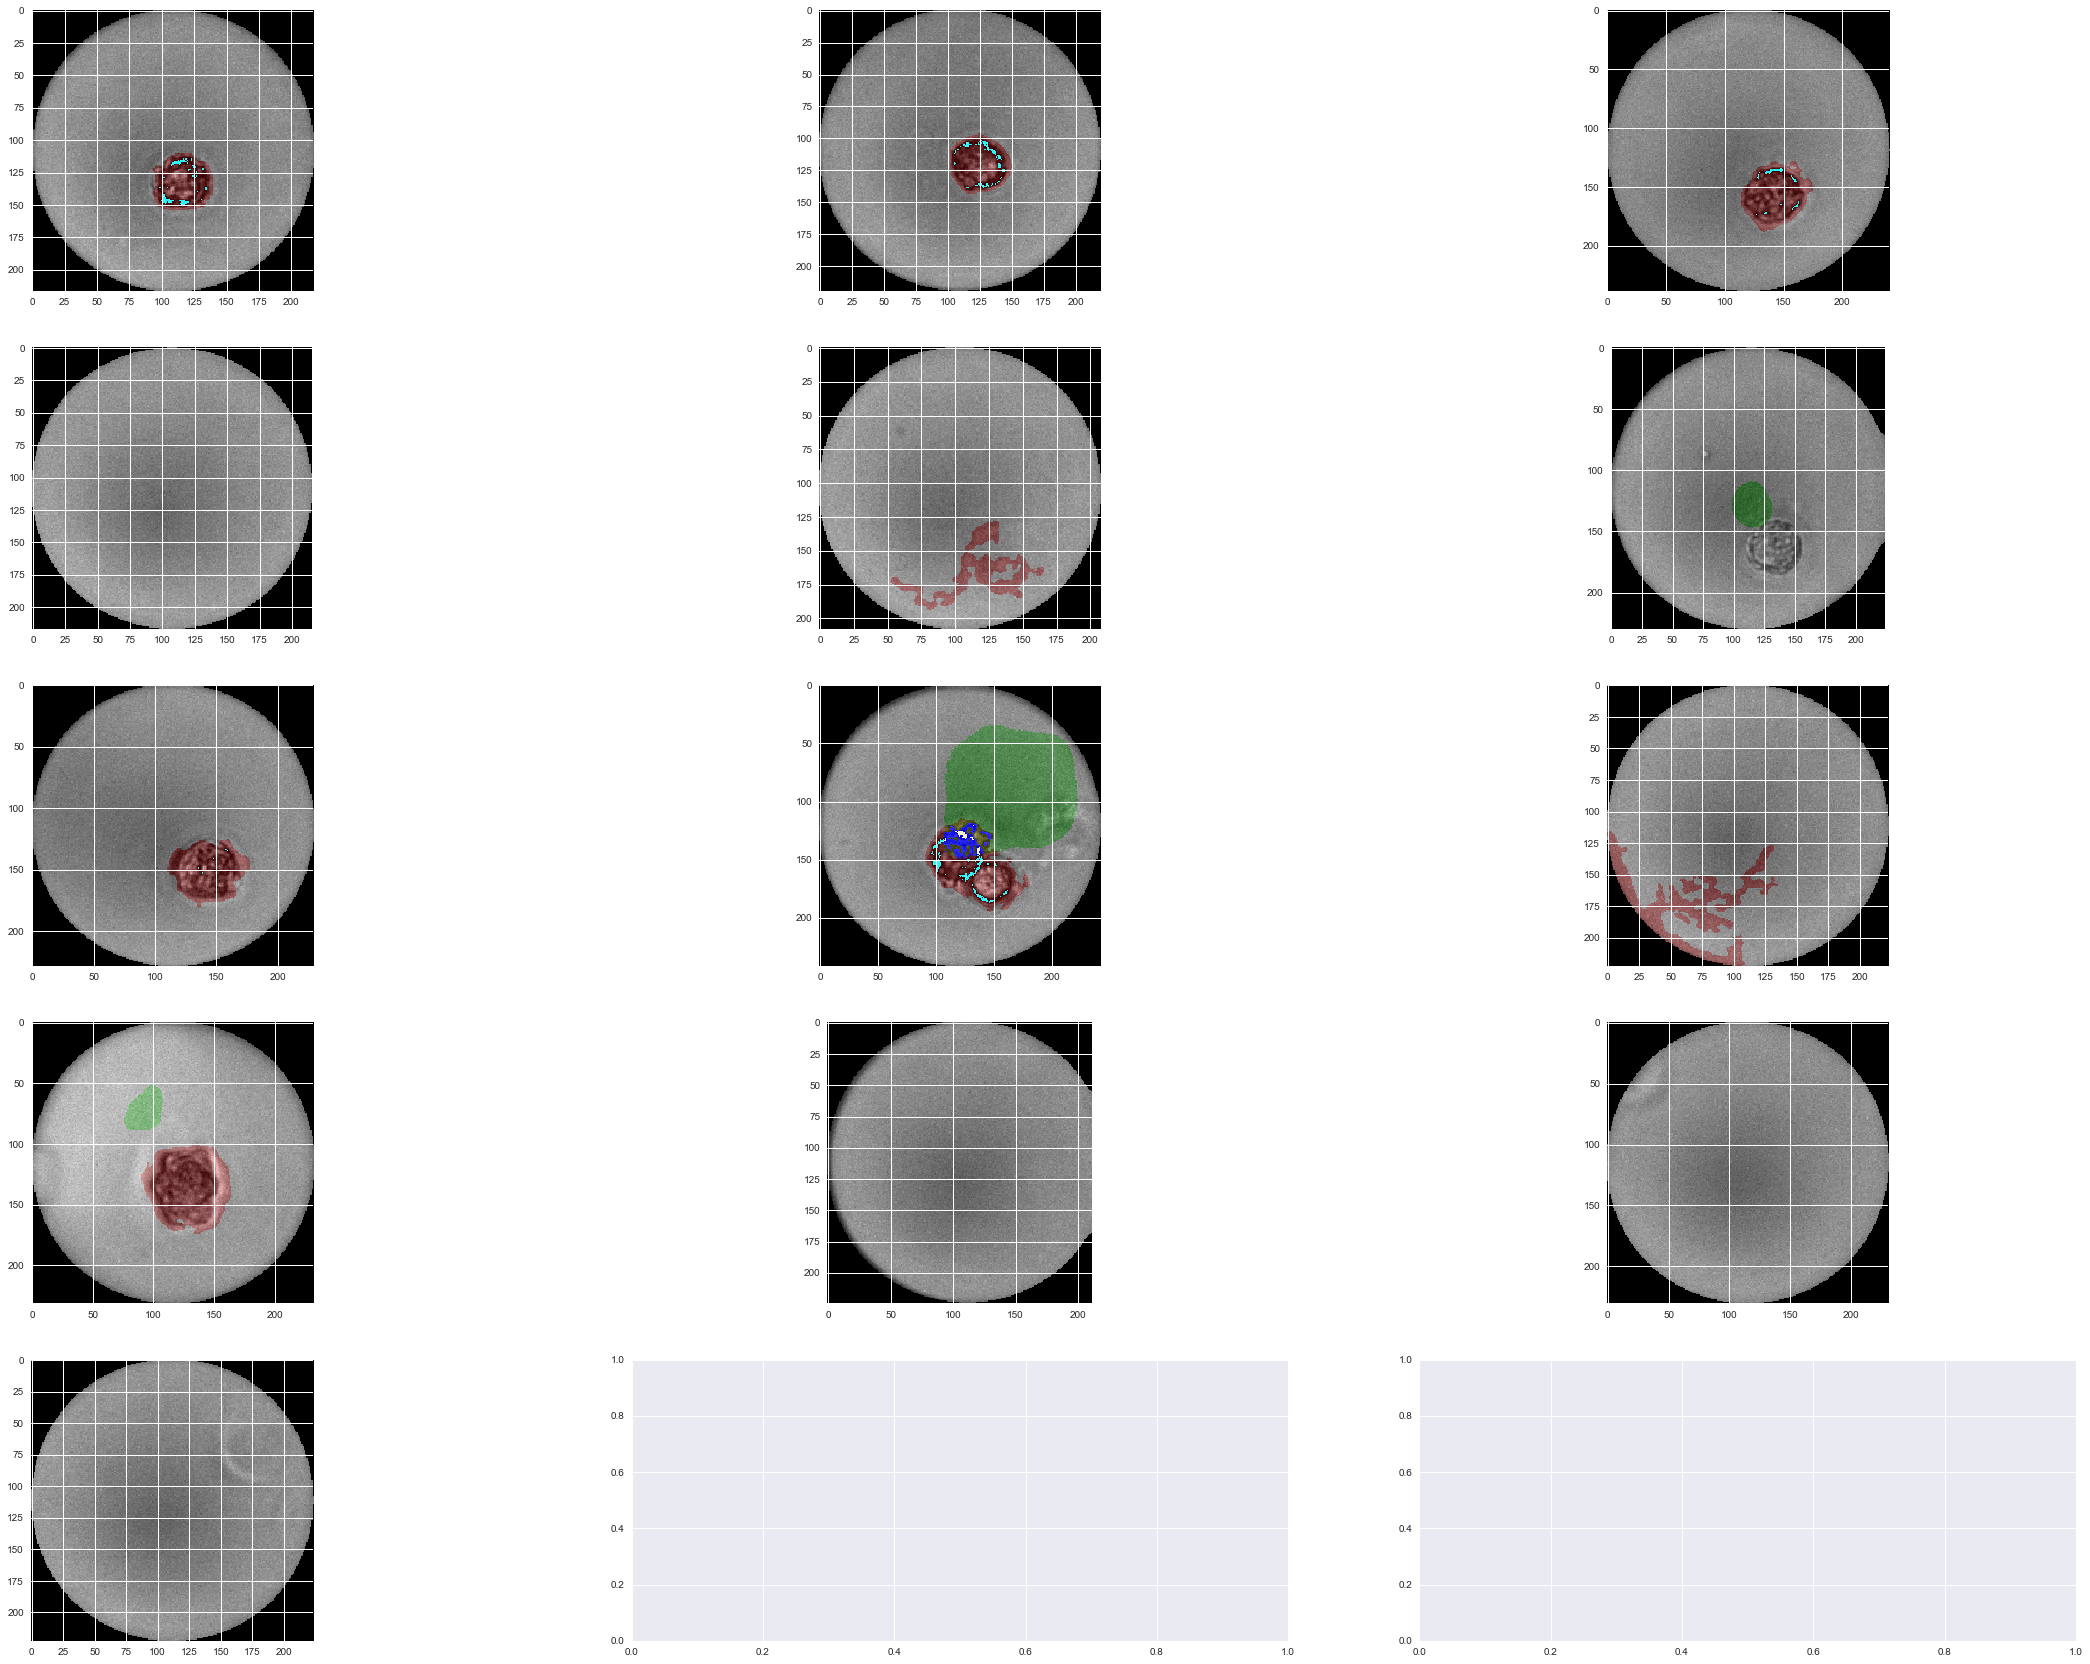

In [625]:
num_rows = (len(droplet_cells_list) // 3) + 1
fig, ax = plt.subplots(num_rows, 3, figsize=(40, 30))
for i in range(num_rows):
    for j in range(3):
        num = i * 3 + j
        try:
            temp_rgb = skimage.color.grey2rgb(test_image_props[num].intensity_image)
            temp_rgb[:, :, 1] = temp_rgb[:, :, 1] + droplet_cells_list[num] * 200
            temp_rgb[:, :, 2] = temp_rgb[:, :, 2] + droplet_cells_list[num] * 200
            temp_rgb[:, :, 0] = temp_rgb[:, :, 0] + (gfp_droplets[num] > 50) * 200
            temp_rgb[:, :, 2] = temp_rgb[:, :, 2] + (gfp_droplets[num] > 50) * 200
            ax[i, j].imshow(temp_rgb)
        except:
            break
plt.show()